# **Wprowadzenie do sztucznej inteligencji**
### Tomasz Gruzdzis 171898
### Krzysztof Wicki 171703


Katedra Inyżnierii Biomedyczna,
Wydział Elektroniki, Telekomunikacji i Informatyki


## 1. Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.svm import SVC, LinearSVC

import sklearn.metrics as metrics

from matplotlib import pyplot as plt

## 2. Odczyt danych

In [2]:
df = pd.read_csv('arrhythmia.data', header=None, na_values = '?')
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(125), int64(155)
memory usage: 988.9 KB
None


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,13.0,64.0,-2.0,NaN,63.0,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37.0,-17.0,31.0,NaN,53.0,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34.0,70.0,66.0,23.0,75.0,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11.0,-5.0,20.0,NaN,71.0,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13.0,61.0,3.0,NaN,NaN,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [3]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,444.000000,430.000000,451.000000,76.000000,451.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.00000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,36.150901,48.913953,36.716186,-13.592105,74.463415,5.628319,51.628319,20.920354,0.141593,0.0,30.035398,0.002212,0.011062,0.011062,0.004425,0.004425,0.008850,5.619469,54.336283,20.59292,0.433628,0.150442,31.637168,0.017699,0.028761,0.002212,0.004425,0.004425,0.015487,16.026549,...,-0.653540,8.039602,-10.150664,0.032965,-0.013496,0.226770,3.894690,-8.269027,32.422788,0.001106,-0.297566,11.839381,-7.034513,0.025664,-0.002876,0.547788,2.535841,10.081195,33.328540,-0.285398,-0.277212,11.369912,-3.607522,0.016814,0.0,0.546681,1.722124,17.840044,32.871460,-0.302434,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,57.858255,29.346409,36.020725,127.220248,13.870684,10.650001,18.249901,20.541728,1.569483,0.0,10.046393,0.047036,0.104708,0.104708,0.066445,0.066445,0.093759,11.220680,17.248213,21.06105,3.093161,2.692591,9.624951,0.132002,0.167319,0.047036,0.066445,0.066445,0.123615,21.906457,...,3.414085,5.279719,7.066568,0.390403,0.264398,0.548988,2.990809,32.157008,37.362289,1.015566,1.758544,5.917391,5.061472,0.166763,0.046287,0.426941,2.429776,25.074695,34.361665,0.675060,0.992472,4.793656,2.850633,0.275907,0.0,0.370548,1.708190,16.445472,24.421643,0.603551,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,-177.000000,-170.000000,-135.000000,-179.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-32.900000,0.000000,-48.400000,0.000000,-5.600000,-3.100000,-11.800000,-242.400000,-146.200000,-3.200000,-20.400000,0.000000,-42.900000,0.000000,-0.900000,-2.600000,-8.200000,-124.800000,-161.400000,-4.800000,-14.200000,0.000000,-30.800000,0.000000,0.0,-0.900000,-5.000000,-56.800000,-63.600000,-5.600000,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,14.000000,41.000000,12.000000,-124.500000,65.000000,0.000000,40.000000,0.000000,0.000000,0.0,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.00000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.200000,-13.000000,0.000000,0.000000,0.000000,2.000000,-19.525000,9.850000,-0.500000,0.000000,7.875000,-9.100000,0.000000,0.000000,0.400000,1.100000,-0.925000,11.275000

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 1 to 451
Columns: 279 entries, Age to Target
dtypes: float64(124), int64(155)
memory usage: 958.1 KB


In [4]:
column_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,279]
new_names = [
             "Age", "Sex", "Height", "Weight",
             "QRS duration","P-R interval",
             "Q-T interval","T interval",
             "P interval","QRS","T","P",
             "QRST","Heart rate","Target"
]
old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.head(5)

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,T,P,QRST,13,Heart rate,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,Target
0,75,0,190,80,91,193,371,174,121,-16,13.0,64.0,-2.0,NaN,63.0,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37.0,-17.0,31.0,NaN,53.0,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34.0,70.0,66.0,23.0,75.0,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11.0,-5.0,20.0,NaN,71.0,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13.0,61.0,3.0,NaN,NaN,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [5]:
corr_matrix = df.corr()
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
strong_pairs = strong_pairs[abs(strong_pairs) < 1]

print(strong_pairs)

194  55    -1.000000
55   194   -1.000000
254  127   -0.999287
127  254   -0.999287
214  79    -0.967353
              ...   
203  66     0.941517
115  243    0.966664
243  115    0.966664
150  273    0.997769
273  150    0.997769
Length: 1292, dtype: float64


In [77]:
corr_matrix['Target'].sort_values(ascending=False).head(20)

Target          1.000000
90              0.368876
QRS duration    0.323879
92              0.313982
102             0.282523
223             0.235488
233             0.218811
17              0.195198
29              0.183083
94              0.174346
52              0.173243
125             0.170670
191             0.165693
68              0.152534
239             0.151782
77              0.143284
152             0.141506
221             0.141274
56              0.141103
113             0.140502
Name: Target, dtype: float64

## 3. Wstepne przetwarzanie 

In [6]:
miss_total = df.isnull().sum().sort_values(ascending=False)
miss_relative=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
miss_data = pd.concat([miss_total, miss_relative], axis=1, keys=['Total', 'Relative'])
miss_data.head()

,Total,Relative
13,376,0.831858
P,22,0.048673
T,8,0.017699
Heart rate,1,0.002212
QRST,1,0.002212


In [7]:
df = df.drop(columns=[13])

In [8]:
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.mean(), inplace=True)
df.head(5)

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,T,P,QRST,Heart rate,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,Target
0,75,0,190,80,91,193,371,174,121,-16,13.0,64.0,-2.0,63.000000,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,40,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37.0,-17.0,31.0,53.000000,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,24,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34.0,70.0,66.0,75.000000,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,116,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11.0,-5.0,20.0,71.000000,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,52,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13.0,61.0,3.0,74.463415,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,36,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [9]:
df.groupby('Target').count().sort_values([278],ascending=False)

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,T,P,QRST,Heart rate,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278
Target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245
10,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
2,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
6,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
3,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
4,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [10]:
df = df[(df.Target != 8) & (df.Target != 7) & (df.Target != 14) & (df.Target != 15)]

In [11]:
df.shape

(438, 279)

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

scaler=MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## 4. Klasyfikacja

### 4.1 KNN

In [26]:
param_grid={'weights':['distance', 'uniform'], 'n_neighbors':range(1,100)}

grid_search = GridSearchCV( KNeighborsClassifier(),param_grid, cv = 10)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 100),
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print('Best config{}'.format(grid_search.best_estimator_))
print('Best score {:.3f}'.format(grid_search.best_score_))

Best configKNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')
Best score 0.610


In [29]:
knn_clf = KNeighborsClassifier(
    algorithm='auto', leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
    weights='distance'
)
knn_clf.fit(X_train,y_train)
pred = knn_clf.predict(X_test)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.63      0.98      0.77        63
           2       0.00      0.00      0.00        11
           3       1.00      0.67      0.80         6
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.33      0.08      0.13        12
           9       0.00      0.00      0.00         2
          10       1.00      0.11      0.20         9
          16       0.00      0.00      0.00         4

    accuracy                           0.64       110
   macro avg       0.55      0.37      0.40       110
weighted avg       0.56      0.64      0.53       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.5341414141414141


### 4.2 Regresja logistyczna

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

grid_search_log = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search_log.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print('Best config{}'.format(grid_search_log.best_estimator_))
print('Best score {:.3f}'.format(grid_search_log.best_score_))

Best configLogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score 0.719


In [31]:
log = LogisticRegression(
    C=1, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
    warm_start=False
)
log.fit(X_train, y_train)
pred = log.predict(X_test)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.71      0.45      0.56        11
           3       0.83      0.83      0.83         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       1.00      0.08      0.15        12
           9       0.00      0.00      0.00         2
          10       0.86      0.67      0.75         9
          16       0.00      0.00      0.00         4

    accuracy                           0.75       110
   macro avg       0.61      0.50      0.48       110
weighted avg       0.74      0.75      0.68       110



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6834157584157584


### 4.3 Las losowy

In [14]:
param_grid = {"max_depth": range(1,20),
              "max_features": sp_randint(1, 40),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 20),
              "bootstrap": [True, False]}
grid_search_RF = RandomizedSearchCV(RandomForestClassifier(n_estimators=1000), param_distributions=param_grid,
                                   n_iter=30, random_state=0,n_jobs=-1)
grid_search_RF.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [15]:
print('Best config{}'.format(grid_search_RF.best_estimator_))
print('Best score {:.3f}'.format(grid_search_RF.best_score_))

Best configRandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=33,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best score 0.762


In [33]:
rf_clf = RandomForestClassifier(
    bootstrap=False, ccp_alpha=0.0, class_weight=None,
    criterion='gini', max_depth=15, max_features=33,
    max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=2, min_samples_split=11,
    min_weight_fraction_leaf=0.0, n_estimators=1000,
    n_jobs=None, oob_score=False, random_state=None,
    verbose=0, warm_start=False).fit(X_train,y_train)

pred = rf_clf.predict(X_test)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.85      0.97      0.90        63
           2       0.86      0.55      0.67        11
           3       0.71      0.83      0.77         6
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         2
           6       0.80      0.67      0.73        12
           9       1.00      1.00      1.00         2
          10       0.78      0.78      0.78         9
          16       0.00      0.00      0.00         4

    accuracy                           0.82       110
   macro avg       0.59      0.64      0.59       110
weighted avg       0.78      0.82      0.79       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.7919029455393092


### 4.4 SVM

In [20]:
svc = SVC()
param_grid = {'kernel':('rbf', 'sigmoid','linear'),
              'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
              'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10]}

grid_search_svc = GridSearchCV(svc, param_grid, cv = 5)
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10],
                         'kernel': ('rbf', 'sigmoid', 'linear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
print('Best config{}'.format(grid_search_svc.best_estimator_))
print('Best score {:.3f}'.format(grid_search_svc.best_score_))

Best configSVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best score 0.741


In [35]:
svc_clf = SVC(
    C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)
    
pred = svc_clf.predict(X_test)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.72      1.00      0.83        63
           2       1.00      0.27      0.43        11
           3       0.71      0.83      0.77         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00        12
           9       1.00      1.00      1.00         2
          10       1.00      0.67      0.80         9
          16       0.00      0.00      0.00         4

    accuracy                           0.74       110
   macro avg       0.64      0.59      0.56       110
weighted avg       0.67      0.74      0.66       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6630230916985884


### 4.5 Liniowy SVM

In [23]:
lin = LinearSVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
    'max_iter':[1000,10000]}

grid_search_lsvc = GridSearchCV(lin, param_grid, cv = 5)
grid_search_lsvc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
                         'max_iter': [1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
print('Best config{}'.format(grid_search_lsvc.best_estimator_))
print('Best score {:.3f}'.format(grid_search_lsvc.best_score_))

Best configLinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best score 0.716


In [37]:
lin_clf = LinearSVC(
    C=0.5, class_weight=None, dual=True, fit_intercept=True,
    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
    verbose=0).fit(X_train, y_train)
    
pred = lin_clf.predict(X_test)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.78      0.98      0.87        63
           2       0.67      0.55      0.60        11
           3       0.83      0.83      0.83         6
           4       0.50      1.00      0.67         1
           5       1.00      0.50      0.67         2
           6       1.00      0.17      0.29        12
           9       1.00      0.50      0.67         2
          10       0.67      0.67      0.67         9
          16       0.00      0.00      0.00         4

    accuracy                           0.76       110
   macro avg       0.72      0.58      0.58       110
weighted avg       0.76      0.76      0.72       110



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.7181025035570491


## 5. Klasyfikacja po redukcji danych (Te same nastawy algorytmów)

In [39]:
pca = PCA().fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [40]:
d

80

Cumulative sum of Variance


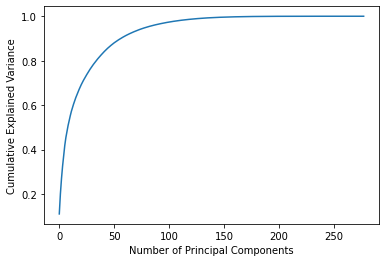

In [41]:
print('Cumulative sum of Variance')
plt.plot(cumsum)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance');

In [43]:
pca = PCA(n_components = 80)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### 5.1 KNN

In [44]:
knn_clf = KNeighborsClassifier(
    algorithm='auto', leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
    weights='distance'
)
knn_clf.fit(X_train_pca,y_train)
pred = knn_clf.predict(X_test_pca)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.62      0.98      0.76        63
           2       0.00      0.00      0.00        11
           3       1.00      0.67      0.80         6
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.50      0.08      0.14        12
           9       0.00      0.00      0.00         2
          10       1.00      0.22      0.36         9
          16       0.00      0.00      0.00         4

    accuracy                           0.65       110
   macro avg       0.57      0.38      0.41       110
weighted avg       0.57      0.65      0.55       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.5458793335313135


### 5.2 Regresja logistyczna

In [46]:
log = LogisticRegression(
    C=1, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
    warm_start=False
)
log.fit(X_train_pca, y_train)
pred = log.predict(X_test_pca)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.83      0.45      0.59        11
           3       0.83      0.83      0.83         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       1.00      0.08      0.15        12
           9       1.00      0.50      0.67         2
          10       0.86      0.67      0.75         9
          16       0.00      0.00      0.00         4

    accuracy                           0.75       110
   macro avg       0.73      0.56      0.56       110
weighted avg       0.77      0.75      0.70       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6988049443931796


### 5.3 Las losowy

In [48]:
rf_clf = RandomForestClassifier(
    bootstrap=False, ccp_alpha=0.0, class_weight=None,
    criterion='gini', max_depth=15, max_features=33,
    max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=2, min_samples_split=11,
    min_weight_fraction_leaf=0.0, n_estimators=1000,
    n_jobs=None, oob_score=False, random_state=None,
    verbose=0, warm_start=False).fit(X_train_pca,y_train)

pred = rf_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.65      0.94      0.77        63
           2       0.33      0.09      0.14        11
           3       0.75      0.50      0.60         6
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        12
           9       1.00      0.50      0.67         2
          10       0.40      0.44      0.42         9
          16       0.00      0.00      0.00         4

    accuracy                           0.63       110
   macro avg       0.46      0.39      0.40       110
weighted avg       0.51      0.63      0.54       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.5415178441972701


### 5.4 SVM

In [51]:
svc_clf = SVC(
    C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train_pca, y_train)
    
pred = svc_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.72      1.00      0.84        63
           2       1.00      0.27      0.43        11
           3       0.71      0.83      0.77         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00        12
           9       1.00      1.00      1.00         2
          10       0.86      0.67      0.75         9
          16       0.00      0.00      0.00         4

    accuracy                           0.74       110
   macro avg       0.63      0.59      0.55       110
weighted avg       0.66      0.74      0.66       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6621182151182151


### 5.5 Liniowy SVM

In [53]:
lin_clf = LinearSVC(
    C=0.5, class_weight=None, dual=True, fit_intercept=True,
    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
    verbose=0).fit(X_train_pca, y_train)
    
pred = lin_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      0.97      0.84        63
           2       1.00      0.45      0.62        11
           3       0.71      0.83      0.77         6
           4       0.25      1.00      0.40         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00        12
           9       1.00      0.50      0.67         2
          10       0.60      0.67      0.63         9
          16       0.00      0.00      0.00         4

    accuracy                           0.73       110
   macro avg       0.59      0.55      0.51       110
weighted avg       0.65      0.73      0.67       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6658923487281019


## 6. Klasyfikacja po redukcji danych

### 6.1 KNN

In [55]:
param_grid={'weights':['distance', 'uniform'], 'n_neighbors':range(1,100)}

grid_search = GridSearchCV( KNeighborsClassifier(),param_grid, cv = 10)
grid_search.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 100),
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
print('Best config{}'.format(grid_search.best_estimator_))
print('Best score {:.3f}'.format(grid_search.best_score_))

Best configKNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='distance')
Best score 0.610


In [57]:
knn_clf = KNeighborsClassifier(
    algorithm='auto', leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
    weights='distance')
knn_clf.fit(X_train_pca,y_train)

pred = knn_clf.predict(X_test_pca)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.62      0.95      0.75        63
           2       0.00      0.00      0.00        11
           3       1.00      0.67      0.80         6
           4       0.50      1.00      0.67         1
           5       1.00      0.50      0.67         2
           6       0.33      0.08      0.13        12
           9       0.00      0.00      0.00         2
          10       1.00      0.22      0.36         9
          16       0.00      0.00      0.00         4

    accuracy                           0.63       110
   macro avg       0.49      0.38      0.38       110
weighted avg       0.55      0.63      0.54       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.5356611570247933


### 6.2 Regresja logistyczna

In [60]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

grid_search_log = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search_log.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [61]:
print('Best config{}'.format(grid_search_log.best_estimator_))
print('Best score {:.3f}'.format(grid_search_log.best_score_))

Best configLogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score 0.723


In [62]:
log = LogisticRegression(
    C=1, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
    warm_start=False)
log.fit(X_train_pca, y_train)

pred = log.predict(X_test_pca)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       0.83      0.45      0.59        11
           3       0.83      0.83      0.83         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       1.00      0.08      0.15        12
           9       1.00      0.50      0.67         2
          10       0.86      0.67      0.75         9
          16       0.00      0.00      0.00         4

    accuracy                           0.75       110
   macro avg       0.73      0.56      0.56       110
weighted avg       0.77      0.75      0.70       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6988049443931796


### 6.3 Las losowy

In [64]:
param_grid = {"max_depth": range(1,20),
              "max_features": sp_randint(1, 40),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 20),
              "bootstrap": [True, False]}
grid_search_RF = RandomizedSearchCV(RandomForestClassifier(n_estimators=1000), param_distributions=param_grid,
                                   n_iter=30, random_state=0,n_jobs=-1)
grid_search_RF.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [65]:
print('Best config{}'.format(grid_search_RF.best_estimator_))
print('Best score {:.3f}'.format(grid_search_RF.best_score_))

Best configRandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=36,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best score 0.631


In [68]:
rf_clf = RandomForestClassifier(
    bootstrap=False, ccp_alpha=0.0, class_weight=None,
    criterion='gini', max_depth=10, max_features=36,
    max_leaf_nodes=None, max_samples=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=7,
    min_weight_fraction_leaf=0.0, n_estimators=1000,
    n_jobs=None, oob_score=False, random_state=None,
    verbose=0, warm_start=False).fit(X_train_pca,y_train)

pred = rf_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.65      0.95      0.77        63
           2       0.33      0.09      0.14        11
           3       0.75      0.50      0.60         6
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        12
           9       1.00      0.50      0.67         2
          10       0.44      0.44      0.44         9
          16       0.00      0.00      0.00         4

    accuracy                           0.64       110
   macro avg       0.46      0.39      0.40       110
weighted avg       0.51      0.64      0.55       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.5479905041195364


### 6.4 SVM

In [70]:
svc = SVC()
param_grid = {'kernel':('rbf', 'sigmoid','linear'),
              'C':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
              'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10]}

grid_search_svc = GridSearchCV(svc, param_grid, cv = 5)
grid_search_svc.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10],
                         'kernel': ('rbf', 'sigmoid', 'linear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [71]:
print('Best config{}'.format(grid_search_svc.best_estimator_))
print('Best score {:.3f}'.format(grid_search_svc.best_score_))

Best configSVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best score 0.717


In [72]:
svc_clf = SVC(
    C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train_pca, y_train)
    
pred = svc_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.72      1.00      0.84        63
           2       1.00      0.27      0.43        11
           3       0.71      0.83      0.77         6
           4       0.33      1.00      0.50         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00        12
           9       1.00      1.00      1.00         2
          10       0.86      0.67      0.75         9
          16       0.00      0.00      0.00         4

    accuracy                           0.74       110
   macro avg       0.63      0.59      0.55       110
weighted avg       0.66      0.74      0.66       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6621182151182151


### 6.4 Liniowe SVM

In [79]:
lin = LinearSVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
    'max_iter':[1000,10000]}

grid_search_lsvc = GridSearchCV(lin, param_grid, cv = 5)
grid_search_lsvc.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000],
                         'max_iter': [1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [80]:
print('Best config{}'.format(grid_search_lsvc.best_estimator_))
print('Best score {:.3f}'.format(grid_search_lsvc.best_score_))

Best configLinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best score 0.726


In [81]:
lin_clf = LinearSVC(
    C=0.1, class_weight=None, dual=True, fit_intercept=True,
    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
    verbose=0).fit(X_train_pca, y_train)
    
pred = lin_clf.predict(X_test_pca)    
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85        63
           2       1.00      0.45      0.62        11
           3       0.71      0.83      0.77         6
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        12
           9       1.00      0.50      0.67         2
          10       0.67      0.67      0.67         9
          16       0.00      0.00      0.00         4

    accuracy                           0.74       110
   macro avg       0.50      0.49      0.45       110
weighted avg       0.64      0.74      0.66       110



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
print(metrics.f1_score(y_test, pred, average='weighted'))

0.6632623007623007
